## Part 2: LAMMPS electrolyte

Interfacial systems are extremely ubiquitous - from membranes in biological systems to electrode-electrolyte interfaces in batteries. In this part of the practical we will explore an interfacial system of relevance for different technological applications, a solution of NaCl in water in contact with graphene.

You have now got experience in running simulations with LAMMPS, and you should have generated a trajectory to analyse. Since it can take quite a while to converge certain properties (longer than you can do in the time of this practical on few cores) we have also provided you with a long `converged' trajectory that you can run your analysis on.


In this section you can run the analysis as you would like -- you can for example explore the broad set of tools available from the _MDAnalysis_ python package, or you are free to write your own analysis scripts, use a different code or some combination of all of the above!

If you would like to use MDAnalysis we have given you a head start in the cell below, loading the `Universe' with which you can use to do your analysis.

In [1]:
#Load libraries you might use
import numpy as np
import ase.io 
import MDAnalysis as mda
from MDAnalysis.analysis.density import DensityAnalysis
from MDAnalysis.analysis.lineardensity import LinearDensity
import ase
from ase import Atoms
from ase.visualize import view
import matplotlib.pyplot as plt
import MDAnalysis.analysis.msd as msdmda


data_path = '/home/nco24/michaelides-share/niamhon/conferences-trips/LJC-SummerSchool/Basic_MD/Part-2/data'
traj = 'traj_unwrapped_0.dcd'
top = 'init_nvt.xyz'

#create universe
u = mda.Universe(f'{data_path}/{top}', f'{data_path}/{traj}', format = 'LAMMPS')
atoms = u.select_atoms('all')   
set(atoms.types)
na = u.select_atoms('name Na')
cl = u.select_atoms('name Cl')
c = u.select_atoms('name C')
ox = u.select_atoms('name O')  

/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


### How does the interface effect the electrolyte struture?

The overall question we want to explore is what is the structure of the electrolyte at the interface? For example, how does the interface effect the bulk properties of the electrolyte?

To address this, the first thing we will look at is the density profile of the electrolyte as a function of distance (in the z direction) from the interface. You should plot the probability as a function of distance. 

**Qs:** Does one ion type (Na or Cl) have a greater propensity to the graphene? Can you think of reasons why?

You should also do a similar analysis for the water.

**Qs:** Can you see after what distance from the graphene the water recovers its bulk density?

Density Profiles

In [9]:
u.add_TopologyAttr('charges')

binsize=0.1
D = LinearDensity(na, delta=1.0, binsize=binsize)
D.run(step=1)

# save output
hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_na = np.array([bincenters, hist]).transpose()
# np.savetxt('density_z.dat', density)

D = LinearDensity(cl, delta=1.0, binsize=binsize)
D.run(step=1)

# save output
hist = D.results['z']['pos']
bincenters = np.arange(len(hist))*binsize
density_cl = np.array([bincenters, hist]).transpose()


/home/nco24/software/anaconda3/envs/caco3/lib/python3.12/site-packages/MDAnalysis/analysis/lineardensity.py:53: DeprecationWarning: `pos` is deprecated and will be removed in version 3.0.0. Please use `mass_density` instead.
  warnings.warn(


Text(0, 0.5, 'Density $\\AA^{-3}$')

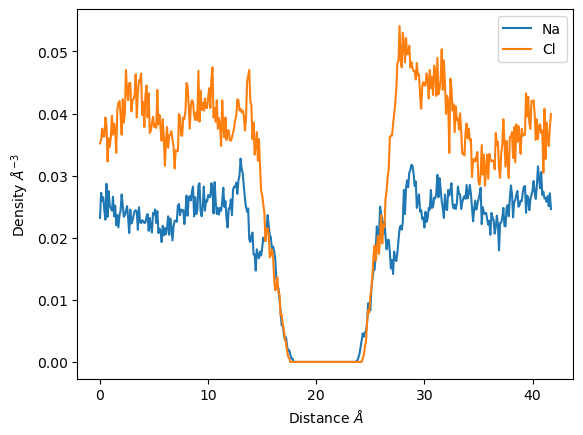

In [10]:
fig, ax = plt.subplots()
ax.plot(density_na[:,0], density_na[:,1], label = 'Na')    
ax.plot(density_cl[:,0], density_cl[:,1], label = 'Cl')
# ax.plot(density_c[:,0], density_c[:,1], label = 'Cl')

ax.legend()
ax.set_xlabel(r'Distance $\AA$')
ax.set_ylabel(r'Density $\AA^{-3}$')

## Water structure

Following from the analysis of the overall structure of the electrolyte, it would also be interesting to understand how the interface effects the orientation of the waters. To look at this you should first define a function that computes the dipole orientation of the water ($\theta$) relative to the z direction. You can then plot a similar probability distribution of $cos(\theta)$ as a function of distance from the interface as you did above for the density.

**Qs:** Do the waters have a preferential orientation closer to the graphene compared to in bulk? 

In [29]:
import numpy as np
import MDAnalysis as mda
from scipy import stats
from MDAnalysis.analysis.density import DensityAnalysis
from MDAnalysis.analysis.distances import distance_array
from MDAnalysis.lib import distances
from MDAnalysis.analysis.lineardensity import LinearDensity
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from MDAnalysis.analysis.waterdynamics import AngularDistribution as AD
from MDAnalysis.analysis.base import AnalysisBase



class orientation(AnalysisBase):
    def __init__(self, atomgroup, axis='z', bins=50, **kwargs):
        super(orientation, self).__init__(atomgroup.universe.trajectory,
                                          **kwargs)
        self._axis = axis
        self._bins = bins
        self._ag = atomgroup

    def _getCosTheta(self, ag, axis):

        oh_dist = distance_array(ag.select_atoms('name O').positions,
                                 ag.select_atoms('name H').positions,
                                 box=ag.dimensions)

        idx = np.argpartition(oh_dist, 3, axis=-1)
        opos = ag.select_atoms('name O').positions
        h1pos = ag.select_atoms('name H')[idx[:,0]].positions
        h2pos = ag.select_atoms('name H')[idx[:,1]].positions

        center = ag.dimensions[:3]/2
        h1pos = distances.apply_PBC(h1pos-opos+center, ag.dimensions)
        h2pos = distances.apply_PBC(h2pos-opos+center, ag.dimensions)

        dipVector0 = (h2pos + h1pos) * 0.5 - center
        unitdipVector0 = dipVector0 / \
        np.linalg.norm(dipVector0, axis=1)[:, None]

        opos = distances.apply_PBC(opos, ag.dimensions)
        if axis == "z":
            valdip = np.array([opos[:,2],unitdipVector0[:,2]])
        elif axis == "x":
            valdip = np.array([opos[:,0],unitdipVector0[:,0]])
        elif axis == "y":
            valdip = np.array([opos[:,1],unitdipVector0[:,1]])

        return (valdip.transpose())

    def _getHistogram(self, CosThetra, bins):

        means, edges, binnumber = stats.binned_statistic(CosThetra[:,:,0].flatten(),
                                                 CosThetra[:,:,1].flatten(),
                                                 statistic='mean', bins=bins)

        edges = 0.5 * (edges[1:] + edges[:-1])
        hist = np.array([edges,means])
        hist = hist.transpose()
        return (hist)


    def _prepare(self):
        # OPTIONAL
        # Called before iteration on the trajectory has begun.
        # Data structures can be set up at this time
        self.CosTheta = []

    def _single_frame(self):
        # REQUIRED
        # Called after the trajectory is moved onto each new frame.
        # store result of `some_function` for a single frame
        self.CosTheta.append(self._getCosTheta(self._ag, self._axis))

    def _conclude(self):
        # OPTIONAL
        # Called once iteration on the trajectory is finished.
        # Apply normalisation and averaging to results here.
        self.CosTheta = np.array(self.CosTheta)
        self.result = self._getHistogram(self.CosTheta, self._bins)



ow = "name O H"
bins = 100
ori_analysis = orientation(u,bins=bins)
ori_analysis.run(step=4)



Text(0, 0.5, 'Probability Density')

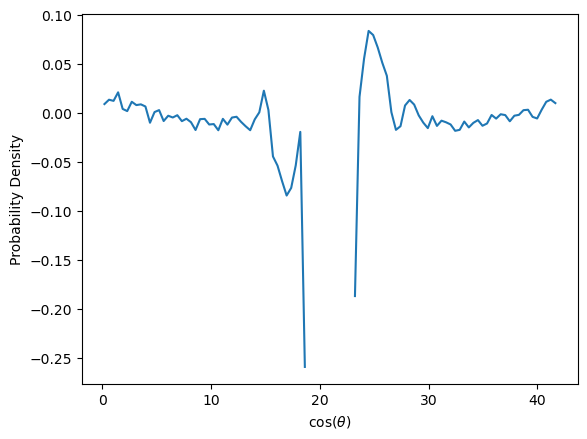

In [31]:
fig, ax = plt.subplots()
ax.plot(ori_analysis.result[:,0], ori_analysis.result[:,1])
ax.set_xlabel(r'$\cos(\theta)$')
ax.set_ylabel('Probability Density')

### Dynamics

Beyond structrual properties, we also want to understand the dynamics of the system. We want to see if there are differences between the diffusion coefficients of the ions and also the water. You can try out the msd module from MDAnalysis and use the Einstein relation to obtain the diffusion coefficient from the slope of a plot of time vs MSD. 

Recall from the lectures that $D = \frac{1}{2d} \frac{d}{dt} \langle r^2(t)\rangle$

**QS:** How can you check how reliable your simulation results are? (Hint: Think about where you decide to fit your MSD curve)

In [18]:
MSD = msdmda.EinsteinMSD(u, select='name Na', msd_type='xyz', fft=True)
MSD.run()


100%|██████████| 9/9 [00:00<00:00, 261.50it/s]


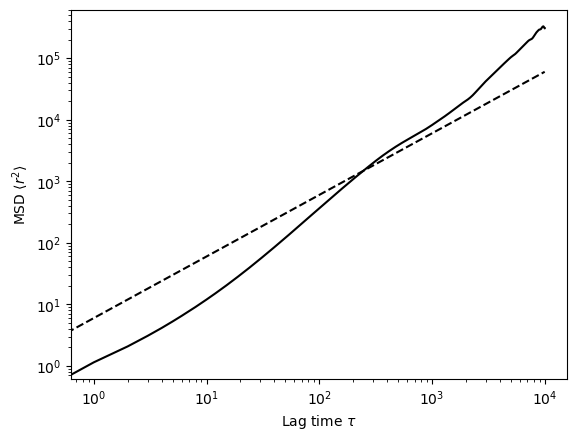

In [28]:
msd =  MSD.results.timeseries
import matplotlib.pyplot as plt
nframes = MSD.n_frames
timestep = 1 # this needs to be the actual time between frames
lagtimes = np.arange(nframes)*timestep # make the lag-time axis
fig = plt.figure()
ax = plt.axes()
# plot the actual MSD
ax.plot(lagtimes, msd, c="black", ls="-", label=r'3D random walk')
exact = lagtimes*6
# plot the exact result
ax.plot(lagtimes, exact, c="black", ls="--", label=r'$y=2 D\tau$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Lag time $\tau$')
ax.set_ylabel(r'MSD $\langle r^2 \rangle$')

plt.show()


**Qs** Do you think we are ready to publish our results? Can you think of some of the weaknesses in the simulations we have run above? For example you can think in terms of 

(a) the physical set-up. What are the constranints we impose on the system? Are these realistic? What would you instead do to improve the setup?

(b) the potential energy surface we use to represent the system. Is this the most accurate description of the system? Are there interactions that we are not accounting for with our current classical model?